# Brain Tumor Classification

# 0. Import

In [40]:
import pandas as pd
import numpy as np
import shutil
import os
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.model_selection import train_test_split
import seaborn as sns
import zipfile
import cv2
import random
from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import time
import copy

# 1. Dataset Overview

- Number of Samples: 5,712 images

- Number of Categories: 4

- 4 classes: glioma, meningioma, no tumor, pituitary.

- Data Source: Brain Tumor MRI Dataset

- https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset/data?select=Training


In [3]:
# Kaggle API 설치
!pip install kaggle

# kaggle.json 파일 업로드
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"jieun1016","key":"5f91bded82725f4c380758edcba63991"}'}

In [4]:
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset

Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
License(s): CC0-1.0
 94% 139M/149M [00:01<00:00, 90.2MB/s]
100% 149M/149M [00:01<00:00, 93.6MB/s]


In [5]:
!unzip -o /content/brain-tumor-mri-dataset.zip -d /content/input/

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: /content/input/Training/glioma/Tr-gl_0712.jpg  
  inflating: /content/input/Training/glioma/Tr-gl_0713.jpg  
  inflating: /content/input/Training/glioma/Tr-gl_0714.jpg  
  inflating: /content/input/Training/glioma/Tr-gl_0715.jpg  
  inflating: /content/input/Training/glioma/Tr-gl_0716.jpg  
  inflating: /content/input/Training/glioma/Tr-gl_0717.jpg  
  inflating: /content/input/Training/glioma/Tr-gl_0718.jpg  
  inflating: /content/input/Training/glioma/Tr-gl_0719.jpg  
  inflating: /content/input/Training/glioma/Tr-gl_0720.jpg  
  inflating: /content/input/Training/glioma/Tr-gl_0721.jpg  
  inflating: /content/input/Training/glioma/Tr-gl_0722.jpg  
  inflating: /content/input/Training/glioma/Tr-gl_0723.jpg  
  inflating: /content/input/Training/glioma/Tr-gl_0724.jpg  
  inflating: /content/input/Training/glioma/Tr-gl_0725.jpg  
  inflating: /content/input/Training/glioma/Tr-gl_0726.jpg  
  inflating: /content/input/Training/glioma/Tr-gl

# 2. Visualization

In [6]:
os.getcwd()

'/content'

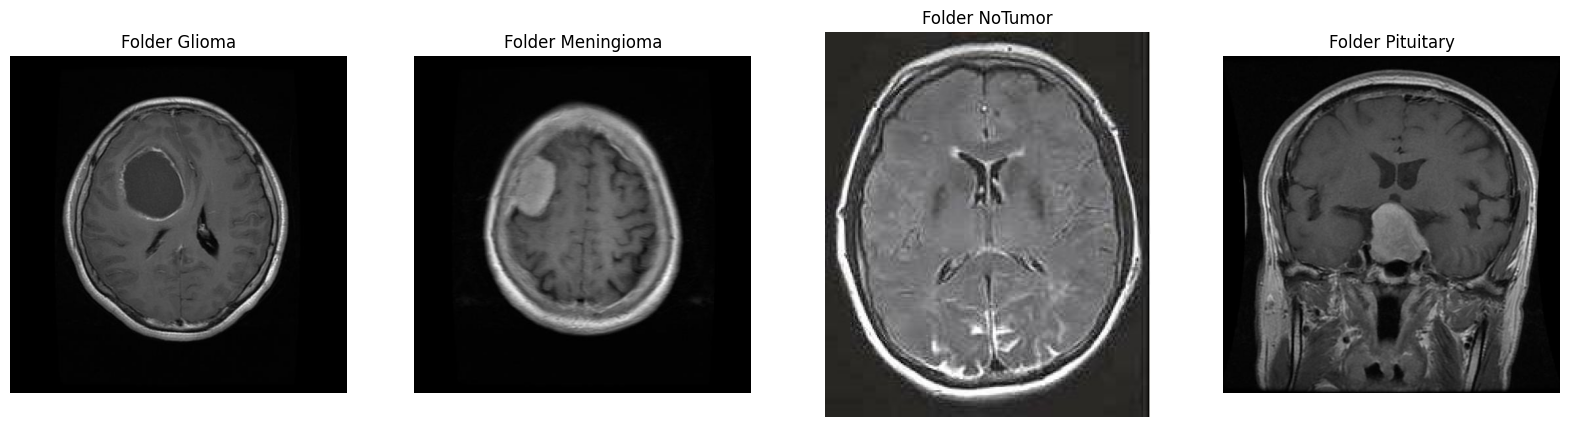

In [7]:
data_dirs = {
    'Glioma': '/content/input/Training/glioma',
    'Meningioma': '/content/input/Training/meningioma',
    'NoTumor': '/content/input/Training/notumor',
    'Pituitary': '/content/input/Training/pituitary'
}

images = {}
for key, dir_path in data_dirs.items():
    images[key] = os.path.join(dir_path, os.listdir(dir_path)[0])

# 이미지 로드 및 시각화
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

for i, (key, img_path) in enumerate(images.items()):
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axes[i].imshow(img_rgb)
    axes[i].set_title(f'Folder {key}')
    axes[i].axis('off')

plt.show()

# 3. Train-test

In [8]:
# 데이터 경로 설정
data_dir = '/content/input/Training'
output_train_dir = '/content/Data/train'
output_test_dir = '/content/Data/test'

In [9]:
# Train/Test 디렉토리 생성
os.makedirs(output_train_dir, exist_ok=True)
os.makedirs(output_test_dir, exist_ok=True)

In [10]:
# 클래스 폴더 이름
classes = ['glioma', 'meningioma', 'notumor', 'pituitary']

In [11]:
# 각 클래스 폴더에 대해 train/test 데이터셋으로 분리
for class_name in classes:
    class_dir = os.path.join(data_dir, class_name)
    train_class_dir = os.path.join(output_train_dir, class_name)
    test_class_dir = os.path.join(output_test_dir, class_name)

    # 디렉토리 생성
    os.makedirs(train_class_dir, exist_ok=True)
    os.makedirs(test_class_dir, exist_ok=True)

    images = os.listdir(class_dir)
    random.shuffle(images)

    # 이미지 800:200
    train_images = images[:800]
    test_images = images[800:1000]

    for image in train_images:
        shutil.copy(os.path.join(class_dir, image), os.path.join(train_class_dir, image))

    for image in test_images:
        shutil.copy(os.path.join(class_dir, image), os.path.join(test_class_dir, image))

# 4. 이미지 전처리

In [12]:
# 이미지 전처리
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [13]:
data_dir = '/content/Data/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'test']}

print(len(image_datasets['train']))
print(len(image_datasets['test']))

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=2) for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

3200
800


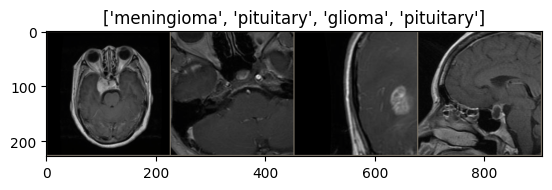

In [22]:
def imshow(inp, title=None):
    """ 텐서를 numpy로 변환 """
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

inputs, classes = next(iter(dataloaders['train']))

out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

# 5_1. 모델 정의

In [14]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()
for idx, para in enumerate(net.parameters()):
  print(f"idx:{idx+1}, para.shape:{para.shape}")
print()
for key, value in net.state_dict().items():
  print(f"{key} : {value.shape}")

idx:1, para.shape:torch.Size([6, 3, 5, 5])
idx:2, para.shape:torch.Size([6])
idx:3, para.shape:torch.Size([16, 6, 5, 5])
idx:4, para.shape:torch.Size([16])
idx:5, para.shape:torch.Size([120, 400])
idx:6, para.shape:torch.Size([120])
idx:7, para.shape:torch.Size([84, 120])
idx:8, para.shape:torch.Size([84])
idx:9, para.shape:torch.Size([10, 84])
idx:10, para.shape:torch.Size([10])

conv1.weight : torch.Size([6, 3, 5, 5])
conv1.bias : torch.Size([6])
conv2.weight : torch.Size([16, 6, 5, 5])
conv2.bias : torch.Size([16])
fc1.weight : torch.Size([120, 400])
fc1.bias : torch.Size([120])
fc2.weight : torch.Size([84, 120])
fc2.bias : torch.Size([84])
fc3.weight : torch.Size([10, 84])
fc3.bias : torch.Size([10])


In [15]:
for name, para in net.named_modules():
  print(f"{name}:*:{para}")

:*:Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)
conv1:*:Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
pool:*:MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
conv2:*:Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
fc1:*:Linear(in_features=400, out_features=120, bias=True)
fc2:*:Linear(in_features=120, out_features=84, bias=True)
fc3:*:Linear(in_features=84, out_features=10, bias=True)


# 5. 모델링

In [16]:
# 모델 정의
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):  #with torch.no_grad():
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [51]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(preds[j].item()))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)


In [18]:
temp_model = models.resnet18(pretrained=True)
#for k, v in temp_model.state_dict().items():
#  print(f"{k} : {v.shape}")
for name, para in temp_model.named_modules():
  print(f"{name}:*:{para}")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 89.6MB/s]


:*:ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)

In [19]:
for param in temp_model.parameters():
  print(f"required_grad:{param.requires_grad}")

required_grad:True
required_grad:True
required_grad:True
required_grad:True
required_grad:True
required_grad:True
required_grad:True
required_grad:True
required_grad:True
required_grad:True
required_grad:True
required_grad:True
required_grad:True
required_grad:True
required_grad:True
required_grad:True
required_grad:True
required_grad:True
required_grad:True
required_grad:True
required_grad:True
required_grad:True
required_grad:True
required_grad:True
required_grad:True
required_grad:True
required_grad:True
required_grad:True
required_grad:True
required_grad:True
required_grad:True
required_grad:True
required_grad:True
required_grad:True
required_grad:True
required_grad:True
required_grad:True
required_grad:True
required_grad:True
required_grad:True
required_grad:True
required_grad:True
required_grad:True
required_grad:True
required_grad:True
required_grad:True
required_grad:True
required_grad:True
required_grad:True
required_grad:True
required_grad:True
required_grad:True
required_gra

In [20]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
print(num_ftrs)

# Here the size of each output sample is set to 4.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 4)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

512


In [21]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=5)

Epoch 0/4
----------


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


train Loss: 0.8609 Acc: 0.6778
test Loss: 0.2402 Acc: 0.9087

Epoch 1/4
----------
train Loss: 0.6642 Acc: 0.7681
test Loss: 0.1673 Acc: 0.9387

Epoch 2/4
----------
train Loss: 0.6168 Acc: 0.7884
test Loss: 0.1722 Acc: 0.9413

Epoch 3/4
----------
train Loss: 0.4840 Acc: 0.8381
test Loss: 0.1291 Acc: 0.9600

Epoch 4/4
----------
train Loss: 0.4757 Acc: 0.8522
test Loss: 0.2537 Acc: 0.9100

Training complete in 88m 38s
Best val Acc: 0.000000


# 6. 성능 평가

In [36]:
def evaluate_model(model, dataloader):
    model.eval()
    y_true = []
    y_pred_proba = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred_proba.extend(torch.nn.functional.softmax(outputs, dim=1).cpu().numpy())

    y_true = np.array(y_true)
    y_pred_proba = np.array(y_pred_proba)

    # Compute ROC-AUC score
    roc_auc = roc_auc_score(y_true, y_pred_proba, average='macro', multi_class='ovr')

    # Compute F1 Score
    f1 = f1_score(y_true, np.argmax(y_pred_proba, axis=1), average='macro')

    return y_true, y_pred_proba, roc_auc, f1

# 모델 평가
y_true, y_pred_proba, roc_auc, f1 = evaluate_model(model_ft, dataloaders['test'])
print(f'ROC-AUC Score: {roc_auc}')
print(f'F1 Score: {f1}')


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


ROC-AUC Score: 0.5750416666666667
F1 Score: 0.20292813871532325
